# Dry Bulk Flows

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/DryBulkFlows.ipynb). 

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
!pip install signal-ocean

In [ ]:
signal_ocean_api_key = '' #replace with your subscription key

## Call the Voyages API
The Voyages API retrieves information about vessel voyages.

In [ ]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.voyages import Vessel, VesselFilter
from signal_ocean.voyages import VesselType, VesselTypeFilter
from signal_ocean.voyages import VesselClass, VesselClassFilter
import pandas as pd
from datetime import date, timedelta, datetime
import plotly.express as px

In [ ]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

Get vessel class ids for Dry  vessel classes

In [2]:
vessel_classes = api.get_vessel_classes()
vessel_classes_df = pd.DataFrame(v.__dict__ for v in vessel_classes)
vessel_classes_df[vessel_classes_df['vessel_type']=='Dry'].head(10)

,vessel_class_id,vessel_class_name,vessel_type_id,vessel_type
4,69,VLOC,3,Dry
5,70,Capesize,3,Dry
6,72,Post Panamax,3,Dry
7,74,Panamax,3,Dry
8,75,Supramax,3,Dry
9,76,Handymax,3,Dry
10,77,Handysize,3,Dry
19,92,Small,3,Dry


### Get voyages for Capesize
For Capesize we will use (vessel_class_id = 70) when calling the API

In [3]:
voyages = api.get_voyages_condensed(vessel_class_id=70, date_from=datetime.strptime("2019-09-01", "%Y-%m-%d"))
voyages = pd.DataFrame([v.__dict__ for v in voyages])
voyages.tail(5)

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
26087,9939333,1,3,70,1,4345.0,False,None,I97A98546VED9F92D00,1,...,2022-08-03 23:55:12+00:00,121.0,Japan,None,Japan Island,True,False,False,False,False
26088,9939333,2,3,70,1,4345.0,False,None,I97A98546VEDA6FD400,2,...,2022-11-07 10:54:17.510000+00:00,55.0,China,None,North China,False,False,False,False,False
26089,9939345,1,3,70,1,4345.0,False,None,I97A99146VEDA20BA00,2,...,2022-10-22 10:43:44.164000+00:00,55.0,China,None,North China,True,False,False,False,False
26090,9939357,1,3,70,1,NaN,False,None,I97A99D46VEDA484700,2,...,2022-11-10 15:46:31.308000+00:00,55.0,China,None,North China,True,False,False,False,False
26091,9939369,1,3,70,1,NaN,False,None,I97A9A946VEDA6FD400,2,...,NaT,NaN,None,None,None,True,False,False,False,True


Convert Timestamp to datetime, drop voyages with first_load_sailing_date in the future (ongoing or future)

In [4]:
voyages['first_load_sailing_date'] = voyages['first_load_sailing_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['first_load_sailing_date']<datetime.now()]

## Examine Capesize Australia Capesize Coal Exports
Group by origin and destination (first load, last discharge), and use first_load_sailing_date as date of export

In [5]:
coal_exports_country_level = voyages[(voyages['first_load_sailing_date']>"2020-01-01")&(voyages['cargo_group']=='Coal')] \
    .set_index('first_load_sailing_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'first_load_sailing_date': 'Date'})

Drop intra country flows

In [6]:
coal_exports_country_level = coal_exports_country_level[coal_exports_country_level['first_load_country_name']!=coal_exports_country_level['last_discharge_country_name']]
coal_exports_country_level.head()

,first_load_country_name,last_discharge_country_name,Date,quantity
0,Australia,Belgium,2022-04-01,131000.0
1,Australia,Belgium,2022-05-01,139000.0
2,Australia,Brazil,2020-01-01,105000.0
3,Australia,Brazil,2020-02-01,0.0
4,Australia,Brazil,2020-03-01,164000.0


* Keep only Australia exports
* Aggregate all exports monthly
* Drop unnecessary columns

In [7]:
australia_coal_exports = coal_exports_country_level[(coal_exports_country_level['first_load_country_name']=='Australia')].copy()

australia_coal_exports['TotalExports'] = australia_coal_exports['quantity'].groupby(australia_coal_exports['Date']).transform('sum')
australia_coal_exports.drop_duplicates(subset=['Date'], keep='last', inplace = True)
australia_coal_exports.drop(['last_discharge_country_name', 'quantity'], axis=1, inplace = True)
australia_coal_exports.head()

,first_load_country_name,Date,TotalExports
457,Australia,2022-09-01,4297000.0
471,Australia,2020-01-01,11371000.0
472,Australia,2020-02-01,10246000.0
473,Australia,2020-03-01,10973000.0
502,Australia,2020-04-01,11306000.0


### Plot Australia Capesize Coal exports

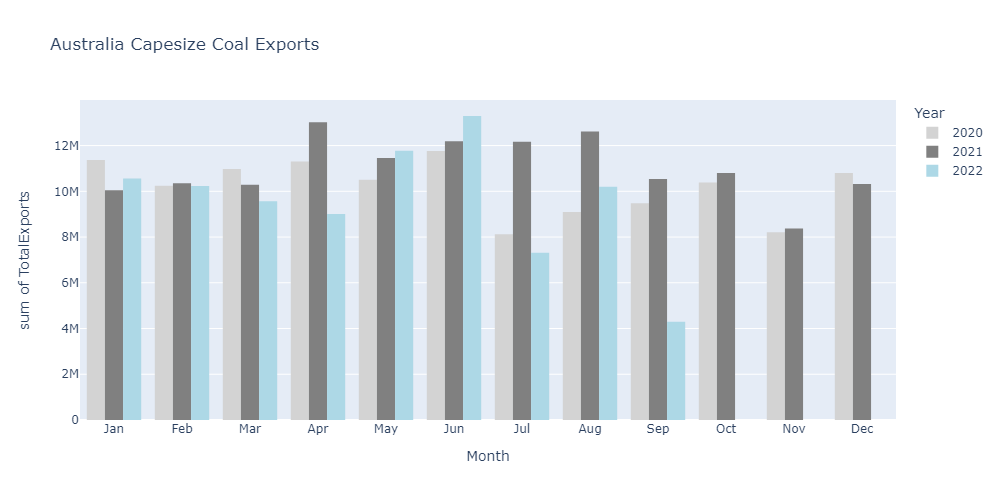

In [8]:
australia_coal_exports['Year'] = australia_coal_exports['Date'].apply(lambda date : date.year)
australia_coal_exports['Month'] = australia_coal_exports['Date'].apply(lambda date : date.month)
australia_coal_exports.sort_values(['Month', 'Year'], inplace = True)
australia_coal_exports['Month'] = australia_coal_exports['Date'].apply(lambda date : date.strftime("%b"))

fig = px.histogram(australia_coal_exports, x="Month", y="TotalExports", color='Year',
             barmode='group', height=500, width=1000,
             title='Australia Capesize Coal Exports',
             color_discrete_sequence=["lightgray", "gray", "lightblue"])
fig.show()

## Examine Australia to China Capesize Iron Ore Flows - Imports to China
Convert Timestamp to datetime, drop voyages with last_discharge_arrival_date in the future (ongoing or future voyages)

In [9]:
voyages['last_discharge_arrival_date'] = voyages['last_discharge_arrival_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['last_discharge_arrival_date']<datetime.now()]
voyages.head()

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
0,9074195,57,3,70,1,2334.0,False,None,I8A7613VED52F1A00,1,...,2020-01-25 23:56:26+00:00,112.0,India,None,East Coast India,False,False,False,False,False
2,9077329,54,3,70,1,672.0,False,None,I8A8251VED5078D00,1,...,2019-12-23 03:40:59+00:00,112.0,India,None,East Coast India,False,False,False,False,False
4,9087295,60,3,70,1,672.0,False,None,I8AA93FVED5078D00,1,...,2019-11-27 21:09:03+00:00,129.0,"Korea, Republic of",None,Korea,False,False,False,False,False
6,9111917,56,3,70,1,374.0,False,None,I8B096DVED52F1A00,1,...,2019-11-29 19:55:54+00:00,112.0,India,None,Pakistan / West Coast India,False,False,False,False,False
7,9111917,57,3,70,1,374.0,False,None,I8B096DVED556A700,1,...,2020-01-26 15:59:02+00:00,112.0,India,None,East Coast India,False,False,False,False,False


* Keep only voyages with 'Iron Ore' as cargo group
* Group by origin and destination (first load, last discharge), and use last_discharge_arrival_date as date of flow

In [10]:
iron_ore_flows_country_level = voyages[(voyages['last_discharge_arrival_date']>"2020-01-01")&(voyages['cargo_group']=='Iron Ore')] \
    .set_index('last_discharge_arrival_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'last_discharge_arrival_date': 'Date'})
iron_ore_flows_country_level.head()

,first_load_country_name,last_discharge_country_name,Date,quantity
0,Australia,Australia,2020-01-01,140000.0
1,Australia,Australia,2020-02-01,277000.0
2,Australia,Australia,2020-03-01,424000.0
3,Australia,Australia,2020-04-01,280000.0
4,Australia,Australia,2020-05-01,279000.0


Keep only flows between Australia and China

In [11]:
china_australia_iron_ore_flows = iron_ore_flows_country_level[(iron_ore_flows_country_level['first_load_country_name']=='Australia')&(iron_ore_flows_country_level['last_discharge_country_name']=='China')].copy()
china_australia_iron_ore_flows.head()

,first_load_country_name,last_discharge_country_name,Date,quantity
33,Australia,China,2020-01-01,48284000.0
34,Australia,China,2020-02-01,39584000.0
35,Australia,China,2020-03-01,46092000.0
36,Australia,China,2020-04-01,50168000.0
37,Australia,China,2020-05-01,50691000.0


### Plot Australia to China Capesize Iron Ore Flows - Imports to China

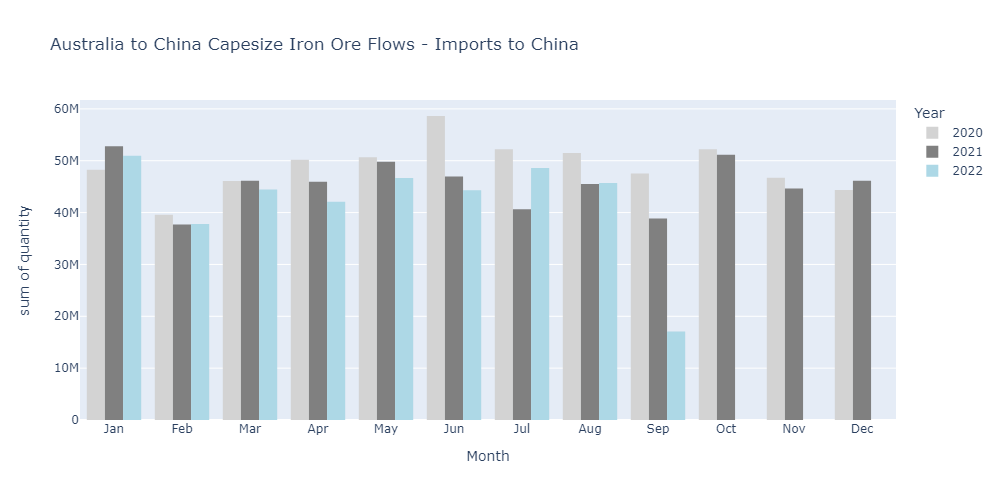

In [12]:
china_australia_iron_ore_flows['Year'] = china_australia_iron_ore_flows['Date'].apply(lambda date : date.year)
china_australia_iron_ore_flows['Month'] = china_australia_iron_ore_flows['Date'].apply(lambda date : date.month)
china_australia_iron_ore_flows.sort_values(['Month', 'Year'], inplace = True)
china_australia_iron_ore_flows['Month'] = china_australia_iron_ore_flows['Date'].apply(lambda date : date.strftime("%b"))

fig = px.histogram(china_australia_iron_ore_flows, x="Month", y="quantity", color='Year',
             barmode='group', height=500, width=1000,
             title='Australia to China Capesize Iron Ore Flows - Imports to China',
             color_discrete_sequence=["lightgray", "gray", "lightblue"])
fig.show()

## Build your custom Flows - Brazil Grain Exports to specific countries by Panamax and Supramax

Get vessel class ids for Dry vessel classes

In [13]:
vessel_classes = api.get_vessel_classes()
vessel_classes_df = pd.DataFrame(v.__dict__ for v in vessel_classes)
vessel_classes_df[vessel_classes_df['vessel_type']=='Dry'].head(10)

,vessel_class_id,vessel_class_name,vessel_type_id,vessel_type
4,69,VLOC,3,Dry
5,70,Capesize,3,Dry
6,72,Post Panamax,3,Dry
7,74,Panamax,3,Dry
8,75,Supramax,3,Dry
9,76,Handymax,3,Dry
10,77,Handysize,3,Dry
19,92,Small,3,Dry


### Select Vessel Classes of interest
Get voyages for selected vessel classes (Panamax and Supramax) starting from a given date

In [14]:
vessel_class_ids = (74, 75) # Get only voyages for Panamax and Supramax
date_from = datetime.strptime("2020-09-01", "%Y-%m-%d")

voyages = []
for vessel_class_id in vessel_class_ids:    
    voyages.append(api.get_voyages_condensed(vessel_class_id=vessel_class_id, date_from=date_from))
    
voyages = pd.DataFrame([v.__dict__ for vc in voyages for v in vc])
voyages.tail(5)

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
92804,9936757,1,3,75,1,NaN,False,None,I979F754BVEDA6FD400,2,...,2022-10-18 04:55:04.351000+00:00,56.0,Colombia,None,West Coast South America,True,False,False,False,False
92805,9936850,1,3,75,1,NaN,False,None,I979FD24BVEDA20BA00,1,...,2022-09-01 23:54:57+00:00,108.0,Indonesia,None,Indonesia,False,False,False,False,False
92806,9936850,2,3,75,1,NaN,False,None,I979FD24BVEDA976100,2,...,2022-10-07 10:05:48.620000+00:00,254.0,South Africa,None,South Africa,False,False,False,False,False
92807,9942811,1,3,75,1,NaN,False,None,I97B71B4BVEDA20BA00,2,...,2022-09-17 00:26:19.538000+00:00,45.0,Canada,None,Canada Atlantic Coast,True,False,False,False,False
92808,9952907,1,3,75,1,NaN,False,None,I97DE8B4BVEDA484700,2,...,2022-09-23 09:39:26.131000+00:00,240.0,United States,None,US West Coast,False,False,False,False,False


Date of flows will be based on the export date
* Convert Timestamp to datetime, drop voyages with first_load_sailing_date in the future (ongoing or future)

In [15]:
voyages['first_load_sailing_date'] = voyages['first_load_sailing_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['first_load_sailing_date']<datetime.now()]
voyages.head()

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
0,7514684,280,3,74,1,3968.0,False,None,I72AA3CVED6E22900,1,...,2020-09-15 03:56:12+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True
1,7514684,281,3,74,1,3968.0,False,None,I72AA3CVED6EF5800,1,...,2020-09-22 11:59:18+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True
2,7514684,282,3,74,1,3968.0,False,None,I72AA3CVED6F5EF80,1,...,2020-09-30 15:59:47+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True
3,7514684,283,3,74,1,3968.0,False,None,I72AA3CVED6FC8700,1,...,2020-10-07 03:56:05+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True
4,7514684,284,3,74,1,3968.0,False,None,I72AA3CVED709B600,1,...,2020-10-24 19:59:45+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True


### Select cargo types of interest
Examine different cargo types under the "Grains" cargo group

In [16]:
voyages[(voyages['cargo_group']=='Grains')&(voyages['cargo_type']!='Grains')].drop_duplicates(subset=['cargo_group', 'cargo_type'], keep='last', inplace = False)[['cargo_group', 'cargo_type']].head(10)

,cargo_group,cargo_type
63564,Grains,Barley
92475,Grains,Sorghum
92751,Grains,Rice
92765,Grains,Soybeans
92771,Grains,Corn
92805,Grains,Wheat


In [17]:
voyages[(voyages['first_load_country_name']=='Brazil')&(voyages['cargo_group']=='Grains')]['cargo_type'].value_counts().head()

Soybeans    2745
Corn         708
Wheat         30
Grains        30
Rice           2
Name: cargo_type, dtype: int64

* Keep only voyages with 'Soybeans' and 'Corn' as cargo type
* Group by origin and destination (first load, last discharge) and cargo type
* Use last_discharge_arrival_date as date of flow

In [18]:
cargo_types_of_interest = ('Soybeans', 'Corn')
custom_flows_country_level = voyages[(voyages['first_load_sailing_date']>"2021-01-01")&(voyages['cargo_type'].isin(cargo_types_of_interest))] \
    .set_index('first_load_sailing_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name', 'cargo_type'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'first_load_sailing_date': 'Date'})
custom_flows_country_level.head()

,first_load_country_name,last_discharge_country_name,cargo_type,Date,quantity
0,Algeria,Colombia,Corn,2022-06-01,35000.0
1,Arabian Gulf,China,Soybeans,2021-07-01,62000.0
2,Argentina,Algeria,Corn,2021-01-01,40000.0
3,Argentina,Algeria,Corn,2021-02-01,38000.0
4,Argentina,Algeria,Corn,2021-03-01,303000.0


### Select flows of interest
Keep only flows between Brazil and (China, South Korea, Japan)

In [19]:
import_countries = ('China', 'Korea, Republic of', 'Japan')
custom_flows = custom_flows_country_level[(custom_flows_country_level['first_load_country_name']=='Brazil')&(custom_flows_country_level['last_discharge_country_name'].isin(import_countries))].copy()
custom_flows.head()

,first_load_country_name,last_discharge_country_name,cargo_type,Date,quantity
1120,Brazil,China,Corn,2021-04-01,91000.0
1121,Brazil,China,Corn,2021-05-01,0.0
1122,Brazil,China,Corn,2021-06-01,53000.0
1123,Brazil,China,Corn,2021-07-01,67000.0
1124,Brazil,China,Corn,2021-08-01,112000.0


### Plot custom flows

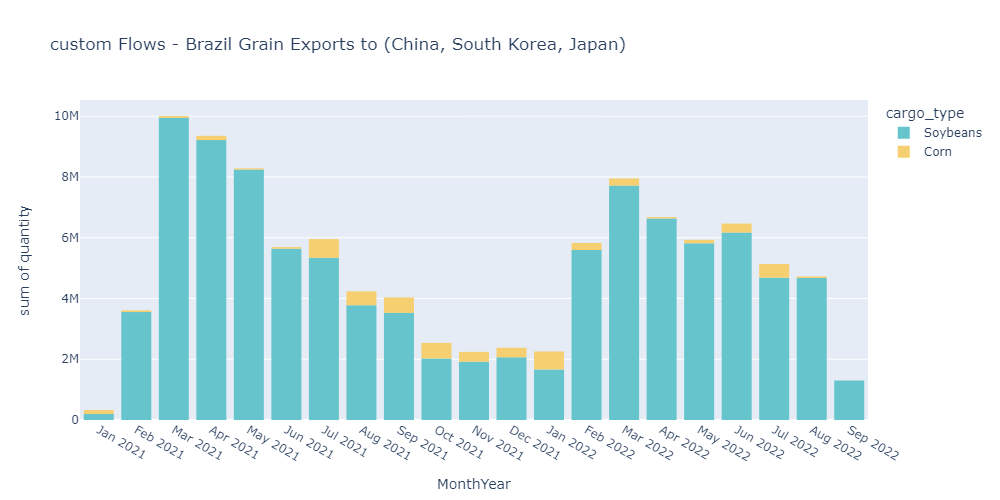

In [20]:
custom_flows['Year'] = custom_flows['Date'].apply(lambda date : date.year)
custom_flows['Month'] = custom_flows['Date'].apply(lambda date : date.month)
custom_flows.sort_values(['Year', 'Month'], inplace = True)

custom_flows['Month'] = custom_flows['Date'].apply(lambda date : date.strftime("%b"))
custom_flows['MonthYear'] = custom_flows['Month'] + ' ' + custom_flows['Year'].astype(str)

fig = px.histogram(custom_flows, x="MonthYear", y="quantity", color='cargo_type',
            height=500, width=1000, title='custom Flows - Brazil Grain Exports to (China, South Korea, Japan)',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(bargap=0.2)
fig.show()